# 계층(Layer)
- 국소적 계산
  - 내가 관심있는 연산만 신경 쓰는 것
  - 계층별로 국소적 계산이 일어난다!
  - 하나의 계층은 하나의일만(국소적) 전문적으로 할 수 있어야 한다.

- 예를들어 ReLU 계층을 만들었으면 ReLU에 대한 순전파, 역전파만 신경쓰자

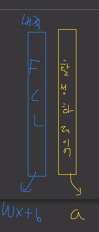

fully connected layer(계층)는 wx+b만

활성화함수계층은 a()만 해주면된다.

# 레이어 구현의 주안점
- 순전파, 역전파를 어떻게 구현해야 할지에 대한 계획을 세워야 한다.
  1. 논문을 보고 하는 경우
    - 논문에 나와있는 순전파, 역전파 수식을 연구
    - 수식을 효율적, 간편하게 짤 수 있는지에 대한 연구(웬만하면 코드 한줄로 마무리)
    - 조건문, 반복문을 최대한 배제(단, 레이어 구축에 대한 논문은 제외...)

  2. 스스로 비즈니스를 만들어서 하는 경우
    - 수식을 세우고 컴퓨터로 테스트를 해 봐야 한다.(수식이 컴퓨터에 효율적인지...)
    - overflow, underflow등 컴퓨터에 맞는 수식을 세웟는지 컴퓨터로 검증이 필요하다.

# 1. 곱셈 계층 구현하기
입력이 x,y 일 때
   - forward(순전파) x*y
   - backward(역전파) 바꿔서 곱하기

  비고: forward식에 입력되었던 x,y를 저장하고 있어야 한다. 그래야 backward할 때 반대방향으로 곱해줄 수 있다.

In [1]:
class MulLayer:

  def __init__(self): # 레이어 전체에서 사용할 옵션들(하이퍼파라미터, 변수)를 미리준비
    # 변수 만들어놓기!
    self.x = None
    self.y = None

  def forward(self, x, y):
    # forward식에 입력되었던 x,y를 저장하고 있어야 한다.⭐⭐ 역전파할때 써야해서
    self.x = x 
    self.y = y

    out = x*y
    return out
    

  # dout : 뒷 층에서 흘러 들어오는 미분값
  def backward(self,dout):
    dx = dout * self.y #⭐⭐여기서 사용
    dy = dout * self.x

    return dx, dy

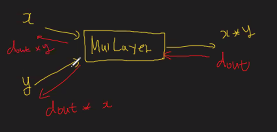

In [2]:
apple = 100 # 사과1개당가격
apple_count = 2 # 사과개수
tax = 1.1 # 소비세

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 모형짜놓은순서 그대로가기!
apple_price = mul_apple_layer.forward(apple, apple_count) # 전체사과가격
price = mul_tax_layer.forward(apple_price, tax) # 소비세적용 전체사과가격

price

220.00000000000003

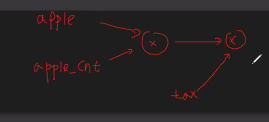

layer가 2개

수행순서 굉장히 중요.

ABC순으로 순전파했으면 CBA순으로 역전파해야됨. 내맘대로 순서바꾸면 안됨!!

In [3]:
# 역전파 수행
dprice = 1 # d돈통/ d포스기

# 미분값 거꾸로 계속 끌고오기
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_count = mul_apple_layer.backward(dapple_price)

print("사과 전체 가격에 대한 미분값 d돈통/d사과전체가격 : {}".format(dapple_price))
print("사과 1개 가격에 대한 미분값 d돈통/d사과1개가격 : {}".format(dapple))
print("사과 개수에 대한 미분값 d돈통/d사과개수 : {}".format(dapple_count))
print("소비세에 대한 미분값 d돈통/d소비세 : {}".format(dtax))

사과 전체 가격에 대한 미분값 d돈통/d사과전체가격 : 1.1
사과 1개 가격에 대한 미분값 d돈통/d사과1개가격 : 2.2
사과 개수에 대한 미분값 d돈통/d사과개수 : 110.00000000000001
소비세에 대한 미분값 d돈통/d소비세 : 200


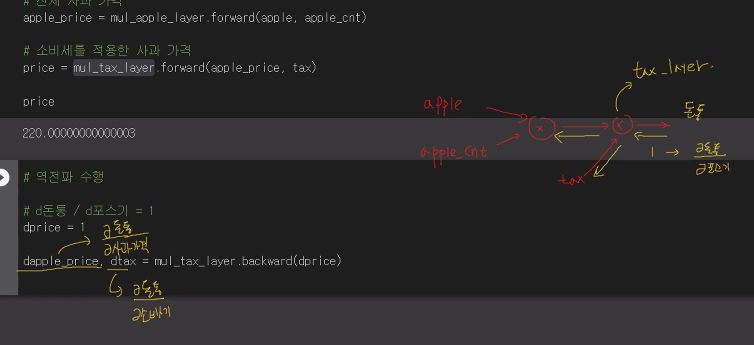

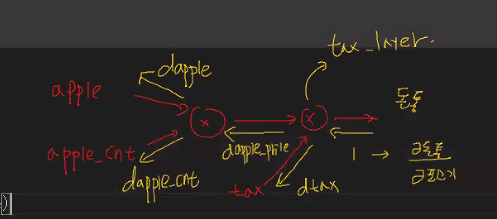

# 덧셈 계층 구현하기
- forward = x+y
- backward = 뒷층에서 보낸 미분값 고대로

비고: 곱셉계층과 다르게 forward시에 입력된 값 없어도됨. 역전파시엔 고대로 미분값만 내보내면 되니깐

In [4]:
class AddLayer:

  def forward(self,x,y):
    out = x + y
    return out

  def backward(self,dout):
    dx = dout * 1
    dy = dout * 1

    return dx, dy

In [5]:
apple = 100 # 사과 1개당가격
apple_count = 2 # 사과 개수

orange = 150 # 오렌지 1개당 가격
orange_count = 3 # 오렌지 개수

tax = 1.1 # 소비세

# 1층 사과에 대한 국소적 계산, 오렌지에 대한 국소적 계산
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()

# 2 계층 - 사과 전체 가격 + 오렌지 전체 가격
add_apple_orange_layer = AddLayer()

# 3 계층 - 소비세 적용
mul_tax_layer = MulLayer()

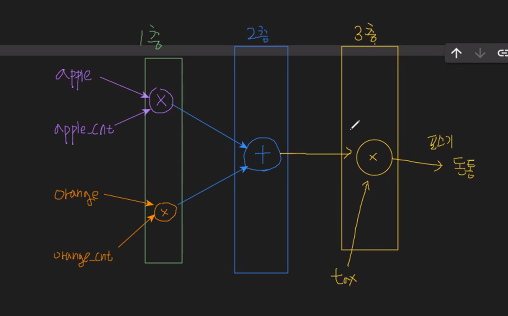

In [6]:
# 순전파

# 1계층 계산
#  사과에 대한 국소적 계산
apple_price = mul_apple_layer.forward(apple, apple_count)

#  오렌지에 대한 국소적 계산
orange_price = mul_orange_layer.forward(orange, orange_count)

# 2계층 계산 ( 사과 전체 가격 + 오렌지 전체 가격 )
total_price = add_apple_orange_layer.forward(apple_price, orange_price)

# 3계층 계산 ( 소비세 적용 )
price = mul_tax_layer.forward(total_price, tax)

In [7]:
price

715.0000000000001

In [8]:
# 역전파
# 그림보고하면 참쉬움❤⭐

dprice = 1 # d돈통/ d포스기

dtotal_price, dtax = mul_tax_layer.backward(dprice)

dapple_price, dorange_price = add_apple_orange_layer.backward(dtotal_price)

dapple, dapple_count = mul_apple_layer.backward(dapple_price)

dorange, dorange_count = mul_orange_layer.backward(dorange_price)

In [9]:
# 책 p163
print("(사과+오렌지)전체 가격에 대한 미분값 d돈통/d과일전체가격 : {}".format(dtotal_price))
print("소비세에 대한 미분값 d돈통/d소비세 : {}".format(dtax))
print("(사과)전체 가격에 대한 미분값 d돈통/d사과전체가격 : {}".format(dapple_price))
print("(오렌지)전체 가격에 대한 미분값 d돈통/d오렌지전체가격 : {}".format(dorange_price))
print("사과 1개 가격에 대한 미분값 d돈통/d사과1개당가격 : {}".format(dapple))
print("사과개수에 대한 미분값 d돈통/d사과개수 : {}".format(dapple_count))
print("오렌지 1개 가격에 대한 미분값 d돈통/d오렌지1개당가격 : {}".format(dorange))
print("오렌지개수에 대한 미분값 d돈통/d오렌지개수 : {}".format(dorange_count))

(사과+오렌지)전체 가격에 대한 미분값 d돈통/d과일전체가격 : 1.1
소비세에 대한 미분값 d돈통/d소비세 : 650
(사과)전체 가격에 대한 미분값 d돈통/d사과전체가격 : 1.1
(오렌지)전체 가격에 대한 미분값 d돈통/d오렌지전체가격 : 1.1
사과 1개 가격에 대한 미분값 d돈통/d사과1개당가격 : 2.2
사과개수에 대한 미분값 d돈통/d사과개수 : 110.00000000000001
오렌지 1개 가격에 대한 미분값 d돈통/d오렌지1개당가격 : 3.3000000000000003
오렌지개수에 대한 미분값 d돈통/d오렌지개수 : 165.0


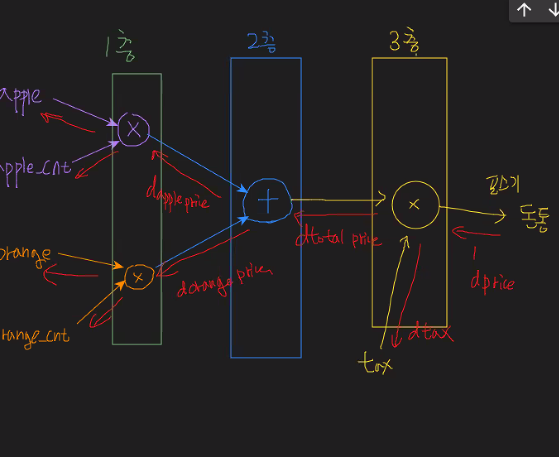

# ReLU
역전파할때 음수였던거 0로 만든다!

In [10]:
class ReLU:
  def __init__(self):

    # mask : 순전파 시에 음수였던 인덱스를 저장하기 위함
    # mask가 있어야 순전파 때 음수였던 부분을 역전파 때 0으로 만들어 줄 수 있다.⭐⭐⭐
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0) # 음수면 True, 양수면 False
    
    out = x.copy() # 원본 배열 복사
    out[self.mask] = 0 # 음수 였던 부분만 0이 된다.

    return out

  def backward(self, dout):
    # 순전파 때 음수였던 부분을 0으로 만들었다.
    # 음수였었던 인덱스를 기억하고 있다가(self.mask) 미분값 전달 시에 해당 인덱스를 0으로 만든다.
    dout[self.mask] = 0
    dx = dout

    return dx

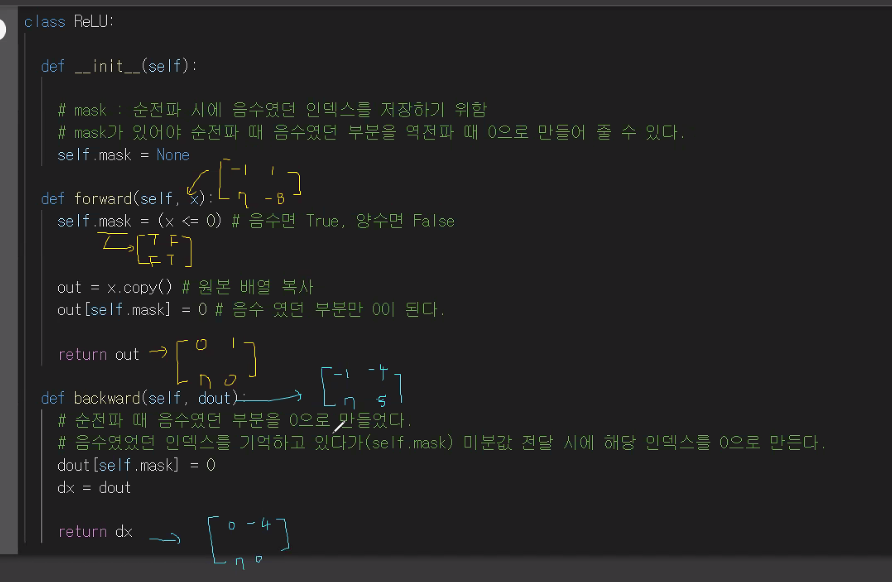

In [11]:
import numpy as np
x = np.array([[1.0, -1.6],[3.2, -8.3]])

relu = ReLU()
relu.forward(x)

array([[1. , 0. ],
       [3.2, 0. ]])

In [12]:
# 입력값이 음수였던 부분이 True
relu.mask

array([[False,  True],
       [False,  True]])

In [13]:
dout = np.array([[-0.1, 3.0],[1.7, -4.5]])

relu.backward(dout)

array([[-0.1,  0. ],
       [ 1.7,  0. ]])

# 시그모이드 구현
y값(forward의 결과물을 알고있어야한다) p169


In [14]:
class Sigmoid:
  def __init__(self):
    # y를 out이라하자
    self.out = None # y값(forward의 결과물을 알고있어야한다)⭐⭐

  def forward(self,x):
    out = 1 / ( 1+ np.exp(-1 * x) )
    self.out = out

    return out

  def backward(self, dout):
    dx = dout * self.out * (1 - self.out) # 그냥 out은 forward꺼라서 밖에서 못쓰기때문에!

    return dx

## Affine(Dense, FCL) 계층
* `forward`
  1. 입력값 `x`와 가중치 `W`의 내적 + `b` (`WX+b`)
  2. 평탄화
    * 1차원 배열로 데이터가 들어왔을 때 대응 ( 배치 정보가 없을 경우 대응 )
    * 다차원 배열( 텐서 )에 대한 대응(배치사이즈제외하고,  나머지일렬로쭉펴줘야 내적가능)
    * **원본 데이터의 형상을 저장** (평탄화이전 정보저장)⭐ 책에 나와있어서 지금만 잠깐함
* `backward`
  1. 미분값(`dout`)과 가중치의 전치행렬(`W.T`) 내적 ( 입력값에 대한 미분값 )$\frac{\partial L}{\partial X}$
  2. 입력값의 전치행렬(`X.T`)과 미분값(`dout`) 내적 ( 가중치에 대한 미분값 )$\frac{\partial L}{\partial W}$
  3. 배치를 축으로 편향 합 구하기 (`axis=0`)
  4. 입력값의 미분값(`dx`)의 형상을 원본 `x`의 형상으로 다시 바꿔주기
      - (60000,28,28) 배열을 (60000, 784) 형식으로 바꿔서 평탄화된 모양을 원래의 (60000, 28, 28)로 바꾼다.

`forward`에 의해서 형상(shape) 변환이 일어나기 때문에 `backward`할 때 원본 모양으로 되돌려 준다.
* `(100, 28, 28)`이 입력으로 들어오면, `forward`에서 평탄화에 의해 `(100, 784)`가 된다.
* 텐서에도 모두 내적을 수행할 수 있도록 원본 형상인 `(100, 28, 28)`저장을 해 놨다가 `backward`할 때 저장했던 원본 모양으로 **미분값 배열**의 형상을 되돌려 준다.

**저장해야 할 값**
1. 원본 `x`의 형상(shape)
2. 원본 `x` 데이터
3. 가중치, 편향
4. `dW`, `db`
  * 미분값을 알고 있어야 나중에 최적화( Optimization )를 할 수 있다.

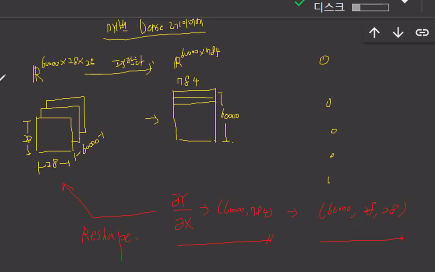

# 역전파 할 때 미분값 형태(60000,28,28) (원본배열이랑 같게)로 맞춰줄꺼라서⭐

In [20]:
class Dense: # = affine이랑 같음. 행렬 곱셈 일어나는 계층
  def __init__(self, W, b):
    # 1. 가중치, 편향, 입력값 정리

    self.W = W
    self.b = b
    self.x = None # x는 forward할 때 들어옴
    self.original_x_shape = None # forward할 때 지정될꺼

    # 2. x의 shape 저장
    # x에 대한 역전파를 수행할 때 모양이 평탄화 되어버린 x의 미분값의 형상을 원래대로 돌려놓기 위해 원본 x의 형상을 저장할 변수
    # 나중가면 딱히 필요 없는 과정
    # 신경망에 데이터를 집어 넣을 때 마다 평탄화 시키지 않아도 되도록 하는거


    # 3. W와 b의 기울기 배열
    # 나중에 경사하강법 수행해야 하므로 가지고있어야(최적화를 위해)
    # dW와 db를 활용해서 W,b를 갱신하는것을 <학습>이라고 한다.

    self.dW = None
    self.db = None


  def forward(self,x):
    # 텐서 대응을 위해 입력값 x의 형상을 저장(필요없긴함 책에있어서 하는거)
    # ex) (3,2,2) 3개의 데이터가 (2,2)모양으로 들어가있는 형태 > (3,4) 를 역전파 할 때 (3,2,2)로 다시 돌려줄려고
    self.original_x_shape = x.shape

    # 평탄화
    DATA_SIZE = x.shape[0] # 배치사이즈
    x = x.reshape(DATA_SIZE, -1)
    self.x = x # 역전파 때 가중치에 내적하기 위해 입력값을 저장해놈. 나중에 x.T곱할때 쓰려고⭐

    out = (self.x @ self.W) + self.b

    return out

  def backward(self, dout):
    dx = dout @ self.W.T
    self.dW = self.x.T @ dout # ⭐요기서 사용
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.original_x_shape) # *언패킹 연산자 튜플(12,3) --> *(12,3) --> 12,3 으로 언패킹한다

    return dx # 입력값 따라갈거라 입력에 대한미분값만 필요함. dw, db는 나중에 최적화할때 쓰일수도있으니 저장해놓은것뿐
    # 흘러들어온거만 쫓아가

## SoftmaxWithLoss 계층(출력층)
* softmax에 의한 분류 및 CEE를 활용한 손실함수를 동시에 구현
* `forward`
  * 순전파 시에는 softmax를 적용하고, loss를 적용
    * 정답 레이블(`t`)
    * 예측값( 소프트맥스 결과물 )
    * loss값 ( 기록용 ) (역전파때 필요한건 아님)
* `backward`
  * 순수한 오차 (`y-t`)를 구해서 이전층에 전달
  * 주의사항 : t가 OHE가 되어있는지, 안 되어있는지에 따라서 코드가 달라짐

In [37]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [17]:
class SoftmaxWithLoss:

  def __init__(self):
    self.y = None # 예측값. 역전파때사용
    self.t = None # 정답값, 역전파때사용
    self.loss = None # 필요는 없지만 시각화 위해 loss도 가지고는 있자

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t) # 포스기에 찍힌 금액

    return self.loss # 포스기에서찍힌 금액 돈통에 집어넣기

  def backward(self, dout=1):
    batch_size = self.t.shape[0] # 오차를 배치사이즈로 나눠줘야되기 때문

    # t가 OHE이 되어있는지, 안되어있는지 고려🤦‍♀️🤦‍♀️🤦‍♀️🤦‍♀️
    # MNIST 예시로보자 y = (N장, 10)꼴로 나오지만 ⭐t = (N,10) 원핫인코딩 / (N,) 레이블인코딩⭐
    if self.y.size == self.t.size: # OHE이 되어있다면
      dx = (self.y - self.t) / batch_size

    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1 # y의 정답인 곳에만 -1해줘라! 0,정답  / 1,정답 / 2,정답 이러케...
      dx = dx / batch_size

    return dx


In [58]:
# 예시
y= np.array([[0.1,0.2,0.7],
             [0.1,0.2,0.7]])
t = np.array([[0,0,1],
              [0,1,0]])

(y-t)

# x가 (2,3)형태였으니 dx도 (2,3)형태로 나와야!

array([[ 0.1,  0.2, -0.3],
       [ 0.1, -0.8,  0.7]])

In [60]:
y= np.array([[0.1,0.2,0.7],
             [0.1,0.2,0.7]])
t = np.array([2,1])

y[[0,1], [2,1]] -= 1 # y = y - 1 이부분들만 1을 빼줘라
y
# x가 (2,3)형태였으니 dx도 (2,3)형태로 나와야!

# 이제 이런형태의 y-t에 MSE를 쓰거나 CEE를 써야 하나의 값으로 나오는거

array([[ 0.1,  0.2, -0.3],
       [ 0.1, -0.8,  0.7]])

## 신경망 레이어를 이용해 MNIST분류 네트워크 구성 해보자! 아래그림형태로 할거

 네트워크 = 레이어들을 쌓아놓은 구조
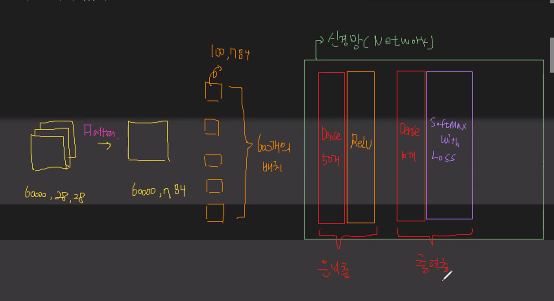

In [19]:
from collections import OrderedDict # 멤버 추가 순서가 유지되는 딕셔너리
#순전파와 역전파는 순서가 중요하기때문

In [43]:
class TwoLayerNet:

  def __init__(self, input_size = 28*28, hidden_size = 50, output_size = 10, weight_init_std=0.01):
    # 매개변수 초기화
    self.params = {}

    # 1층 은닉층을 위한 매개변수 정의
    self.params["W1"] = np.random.randn(input_size, hidden_size) * weight_init_std
    self.params["b1"] = np.zeros(hidden_size)

    # 2층 출력층을 위한 매개변수 정의
    self.params["W2"] = np.random.randn(hidden_size, output_size) * weight_init_std
    self.params["b2"] = np.zeros(output_size)

    # 레이어 쌓기
    # 추가되는 레이어의 순서가 바뀌면 안되기 때문에 OrderedDict활용
    self.layers = OrderedDict()

    # 1층쌓기(은닉층 = fully connected layer)
    self.layers['Dense1'] = Dense(self.params["W1"], self.params["b1"])
    self.layers["ReLU1"] = ReLU()

    # 2층 출력층
    self.layers['Dense2'] = Dense(self.params["W2"], self.params["b2"])
    # 항상 마지막층은 SoftmaxWithLoss가 되어야한다.
    self.lastLayer = SoftmaxWithLoss()


  def predict(self, x): # 순전파
    # self.layers에 들어있는 모든 레이어를 순서대로 꺼내서 forward시킨다.
    for layer in self.layers.values(): # dense1, relu, dense2순서대로 
      x = layer.forward(x)

    return x


  def loss(self,x,t):
    y = self.predict(x)
    return self.lastLayer.forward(y,t)


  def accuracy(self,x,t):
    y = self.predict(x)
    # 굳이 예측단계에서는 softmax함수 쓸 필요 없다
    y = np.argmax(y, axis=1)

    # OHE가 되어있는지 되어있지 않은지가 중요
    # 아까처럼 해도되고 차원으로 비교해도됨. OHE가 된 t는 2차원 배열일거
    if t.ndim != 1:
      t = np.argmax(t,axis=1)

    accuracy = np.sum( y == t) / x.shape[0]

    return accuracy


  # 역전파를 통한 기울기 배열 구하기
  def backward_propagaton(self, x, t):
    # 역전파를 하기위해 순전파가 먼저 필요하다.⭐
    # 손실값을 구하려면 예측을 해서 loss를 계산해야한다.
    self.loss(x,t)

    dout = 1
    # 제일 마지막 층인 SoftmaxWithLoss의 미분값 구하기
    dout = self.lastLayer.backward(dout) # 순수한 오차가 나온다. y-t

    # for 문 돌리기 전에 순서대로 저장되어있던 레이어 모두 가져오기
    # 왜가져와? 거꾸로 타야하므로 순서 뒤집어야함!
    layers = list(self.layers.values()) # [d1, Relu, d2]
    layers.reverse() # [d2, Relu, d1]

    # 이제 for문 타면됨!
    for layer in layers: # [d2, Relu, d1]
      dout = layer.backward(dout)
    # 역전파 수행 다됐다. d2,d1에는 dw, db이런거 다 들어있음.

    # 역전파에 의해 구해진 미분값(기울기)를 가져오기
    grads = {}
    grads["W1"], grads['b1'] = self.layers["Dense1"].dW, self.layers["Dense1"].db
    grads["W2"], grads['b2'] = self.layers["Dense2"].dW, self.layers["Dense2"].db

    return grads



# 이게 예전에 수치미분 500시간걸리던거numerical_gradient(f, W or b)쓰던거 보다 훨씬빠름

미분을 직접안하고 곱하기만 해주기때문
MNIST로 최종테스트 해보자!

In [22]:
from tensorflow.keras import datasets
from sklearn.preprocessing import OneHotEncoder

mnist = datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# dummy는 원핫인코딩 해준거⭐ 복습하기 가로로세워서 먹이고
y_train_dummy = OneHotEncoder().fit_transform(y_train.reshape(-1, 1))
y_train_dummy = y_train_dummy.toarray() # 압축된 희소행렬꼴로 되어있어서 풀어주기

y_test_dummy = OneHotEncoder().fit_transform(y_test.reshape(-1, 1))
y_test_dummy = y_test_dummy.toarray()

# feature 전처리
X_train = X_train.reshape(X_train.shape[0], -1)
X_train = X_train / 255.0 # 이미지 정규화 기법. 255.0 으로 나눠주면 모든 픽셀 데이터가 0 ~ 1사이의 값을 갖게 되고, 훈련이 쉽게 된다.

X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [46]:
network = TwoLayerNet(input_size=28*28, hidden_size=50, output_size=10)

# 하이퍼 파라미터 설정
iter_num = 10000 # 학습 반복 횟수
learning_rate = 0.1 # 학습률
batch_size = 100 # 배치 사이즈
train_size = X_train.shape[0] # 훈련할 이미지의 개수

# 훈련 과정을 1 에폭마다 기록 (시각화)
train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []

# 1에폭을 위한 반복 횟수 구하기
# 배치를 이용해서 전체 데이터를 모두 사용하면 1에폭
iter_per_epoch = int(max(train_size / batch_size, 1))
# max(60000/100, 1) = max(600,1) = 600번 돌아야 1에폭이다.
# 왜굳이 max쓰냐? 훈련데이터 50 / 배치사이즈를 100같은걸로 잘못설정해버리면 오류나서. 1번은 돌아야하므로

for i in range(iter_num):
  # 미니배치생성
  batch_mask = np.random.choice(train_size, batch_size) # 60000개중 100개 인덱스 랜덤뽑아!
  X_batch = X_train[batch_mask]
  t_batch = y_train_dummy[batch_mask]

  # 훈련 1단계 - 기울기계산
  # numerical_gradient_params(x_batch, t_batch)는 줠라게줠라게 느리기때문에 안할거
  grads = network.backward_propagaton(X_batch, t_batch)

  # 훈련 2단계 - 경사하강법 수행(최적화 optimization)
  for key in ["W1", "b1", "W2", "b2"]:
    network.params[key] -= learning_rate * grads[key]

  # 1에폭마다 정확도, loss확인 지금 600회돌아야 1에폭임
  if i % iter_per_epoch == 0: # 600회 돌때마다 기록할거라서
    train_loss = network.loss(X_train, y_train_dummy)
    test_loss = network.loss(X_test, y_test_dummy)

    train_acc = network.accuracy(X_train, y_train_dummy)
    test_acc = network.accuracy(X_test, y_test_dummy)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print("Epoch {} ==> Train Accuracy : {:.6f} / Test Accuracy : {:.6f} / Train Loss : {:.6f} / Test Loss : {:.6f} ".format(int(i/iter_per_epoch), train_acc, test_acc, train_loss, test_loss))

Epoch 0 ==> Train Accuracy : 0.097783 / Test Accuracy : 0.099900 / Train Loss : 2.303063 / Test Loss : 2.303005 
Epoch 1 ==> Train Accuracy : 0.904850 / Test Accuracy : 0.908700 / Train Loss : 0.333708 / Test Loss : 0.323998 
Epoch 2 ==> Train Accuracy : 0.919433 / Test Accuracy : 0.922600 / Train Loss : 0.273661 / Test Loss : 0.270329 
Epoch 3 ==> Train Accuracy : 0.936000 / Test Accuracy : 0.935000 / Train Loss : 0.225104 / Test Loss : 0.224752 
Epoch 4 ==> Train Accuracy : 0.944317 / Test Accuracy : 0.943300 / Train Loss : 0.193189 / Test Loss : 0.193165 
Epoch 5 ==> Train Accuracy : 0.952067 / Test Accuracy : 0.949900 / Train Loss : 0.168123 / Test Loss : 0.170860 
Epoch 6 ==> Train Accuracy : 0.955867 / Test Accuracy : 0.951400 / Train Loss : 0.154317 / Test Loss : 0.160450 
Epoch 7 ==> Train Accuracy : 0.960567 / Test Accuracy : 0.955000 / Train Loss : 0.138196 / Test Loss : 0.145164 
Epoch 8 ==> Train Accuracy : 0.964433 / Test Accuracy : 0.960600 / Train Loss : 0.126072 / Test 

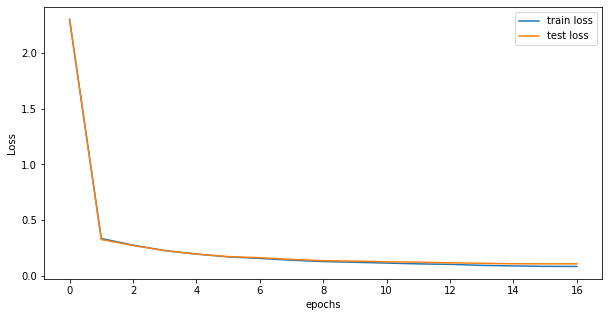

In [47]:
import matplotlib .pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()